# One hot encoding in Pandas and scikit learn

The task at hand is to modify one column with categorical data to n_categories-1 columns with booleans matching the given categories. It is quite easy to do, and there are heaps of implementations. Here I put pandas `get_dummies` versus `sklearn.preprocessing` `OneHotEncoder` and `LabelEncoder` to see which performs better for my applications.

## Environment
### Imports

In [49]:
import random
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

In [40]:
%matplotlib inline

### Helpers

In [25]:
def show(df):
    """Pretty print data frame `df`"""
    display(HTML(df.to_html()))

In [26]:
def fuse_cols(df_source, df_onehot, column):
    """Replace df_source column `column` with `df_onehot` columns"""
    return pd.concat((
        df_source.drop(column, axis=1), df_onehot), axis=1)

In [28]:
def dummy_data(n):
    """Generate dummy data"""
    x = []
    for i in range(n):
        x.append({
            "x" : random.choice(["a", "b", "c", "d"]),
            "y" : i % 10})
    return pd.DataFrame(x)

## Test encoders
### One Hot Encoder wrappers
These functions are intended to produce the same one hot enoded output

In [27]:
def onehot_OHE(df, column):
    """One hot with sklearn.preprocessing.OneHotEncoder"""
    oh = OneHotEncoder(sparse=False, dtype=bool)
    x = oh.fit_transform(df[column].values[:, None])[:, 1:]
    cols = [f"{column}_{c}" for c in oh.categories_[0][1:]]
    return fuse_cols(df, pd.DataFrame(x, columns=cols), column)


def onehot_LB(df, column):
    """One hot with sklearn.preprocessing.LabelBinarizer"""
    lb = LabelBinarizer(sparse_output=False)
    x = lb.fit_transform(df[column].values[:, None]).astype(bool)[:, 1:]
    cols = [f"{column}_{c}" for c in lb.classes_[1:]]
    return fuse_cols(df, pd.DataFrame(x, columns=cols), column)


def onehot_LB(df, column):
    """One hot with pd.get_dummies"""
    x = pd.get_dummies(
        df[column], dtype=bool, sparse=False, drop_first=True, prefix=column)
    return fuse_cols(df, x, column)

### Verify functions give the same output

In [32]:
test_df = dummy_data(20)
print("Input")
show(test_df.head())
print("OneHotEncoder")
show(onehot_OHE(test_df, "x").head())
print("LabelBinarizer")
show(onehot_LB(test_df, "x").head())
print("pd.get_dummies")
show(onehot_LB(test_df, "x").head())

Input


,x,y
0,a,0
1,d,1
2,d,2
3,b,3
4,d,4


OneHotEncoder


,y,x_b,x_c,x_d
0,0,False,False,False
1,1,False,False,True
2,2,False,False,True
3,3,True,False,False
4,4,False,False,True


LabelBinarizer


,y,x_b,x_c,x_d
0,0,False,False,False
1,1,False,False,True
2,2,False,False,True
3,3,True,False,False
4,4,False,False,True


pd.get_dummies


,y,x_b,x_c,x_d
0,0,False,False,False
1,1,False,False,True
2,2,False,False,True
3,3,True,False,False
4,4,False,False,True


Looking good!
### Perform tests with increasing sample size

In [33]:
# Will take a few mins, have a coffee break :)
test_data = {10**i: dummy_data(10**i) for i in range(1, 8)}
for n, test_df in test_data.items():
    print(f"Processing n={n}")
    print("OneHotEncoder")
    %timeit onehot_OHE(test_df, "x")
    print("LabelBinarizer")
    %timeit onehot_LB(test_df, "x")
    print("pd.get_dummies")
    %timeit onehot_PD(test_df, "x")

Processing n=10
OneHotEncoder
1.24 ms ± 26.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
LabelBinarizer
1.27 ms ± 34.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
pd.get_dummies
1.44 ms ± 362 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Processing n=100
OneHotEncoder
1.34 ms ± 32 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
LabelBinarizer
1.39 ms ± 32.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
pd.get_dummies
1.32 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Processing n=1000
OneHotEncoder
1.45 ms ± 49.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
LabelBinarizer
3.01 ms ± 56.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
pd.get_dummies
1.89 ms ± 662 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Processing n=10000
OneHotEncoder
4.13 ms ± 447 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
LabelBinarizer
26 ms ± 1.67 ms per loop (mean ± std. dev. of 7

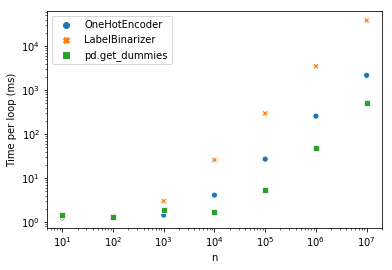

In [57]:
stats = pd.DataFrame([
    [10, 1.24, 1.27, 1.44],
    [100, 1.34, 1.39, 1.32],
    [1000, 1.45, 3.01, 1.89],
    [10000, 4.13, 26, 1.75],
    [100000, 27.1, 296, 5.48],
    [1000000, 257, 3480, 49.1],
    [10000000, 2170, 38300, 516]],
    columns=["n", "OneHotEncoder", "LabelBinarizer", "pd.get_dummies"])
stats.set_index("n", inplace=True)
ax = sns.scatterplot(data=stats)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Time per loop (ms)");

Clearly `LabelBinarizer` suffers with large data, but so does the `OneHotEncoder`, above 100 entries it seems the pandas method is preferable. I suspect this is mainly because of my requirement of getting a fused data frame out of the process.